## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

In [2]:
import matplotlib.patches as patches

In [3]:
from scipy.spatial import Rectangle

In [206]:
class DomainRectangle(Rectangle):
    def __init__(self, mins, maxes, N=None, parent=None,):
        self.parent = parent
        super(DomainRectangle, self).__init__(mins,maxes)
        self.children = []
        self.midpoint = self.mins + (self.maxes-self.mins)/2.

        if N is None: 
            self.N = 0
        else: 
            self.N = N
        
    def __repr__(self):
        return "<DomainRectangle %s>" % list(zip(self.mins, self.maxes))
    
    def split(self, d, split, N): 
        """
        Produce two hyperrectangles by splitting.
        In general, if you need to compute maximum and minimum
        distances to the children, it can be done more efficiently
        by updating the maximum and minimum distances to the parent.
        Parameters
        ----------
        d : int
            Axis to split hyperrectangle along.
        split : float
            Position along axis `d` to split at.
        """
        mid = np.copy(self.maxes)
        mid[d] = split
        less = DomainRectangle(self.mins, mid, N=N, parent=self)
        mid = np.copy(self.mins)
        mid[d] = split
        greater = DomainRectangle(mid, self.maxes, N=N, parent=self)

        return less, greater
    
    def split_domain(self, max_N = 1, N=1): 
        ndim = len(self.maxes)

        # Keep splitting until max level is reached 
        if N <= max_N: 
            split_point = self.mins + (self.maxes - self.mins)/2
            rs = self.split(0,split_point[0],N)

            # split along all dimensions
            for axis in range(1,ndim):
                rs = [r.split(axis,split_point[axis],N) for r in rs]

                if isinstance(rs[0], (tuple, list)):
                    rs = [item for sublist in rs for item in sublist]

            self.children = rs
    
            res = flatten([r.split_domain(max_N, N+1) for r in rs])

            return res

        else: 
            return self


In [207]:
from math import floor, ceil
def get_bin(p, nbins, mins, maxs): 
    px, py = p
    minx, miny = mins
    maxx, maxy = maxs
    dx = (maxx - minx)/float(nbins)
    dy = (maxy - miny)/float(nbins)
  #  dz = (p_maxs['z'] - p_mins['z'])/float(nbins)
    xbin = floor((p[0] - minx)/dx)
    ybin = floor((p[1] - miny)/dy)
 #   zbin = floor((p['z'] + 1)/dz)
    return int(xbin + ybin*nbins)# + zbin*nbins*nbins)

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])


def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
    
def get_rectangle_bin(rec, mins, maxs, nbins):
    # take the midpoint of the rectangle
    point = rec.mins + (rec.maxes - rec.mins)/2.
    return get_bin(point, nbins, mins, maxs)

In [219]:
data = np.zeros((20,2))
for i in range(10): 
    data[i] = np.random.rand(2)*2 - 1 

In [227]:
N=3
D = DomainRectangle([1,1], [-1,-1])
res = D.split_domain(max_N=N)
for r in res: 
    r.bin = get_rectangle_bin(r, D.mins, D.maxes, 2**N)

res.sort(key=lambda x: x.bin)

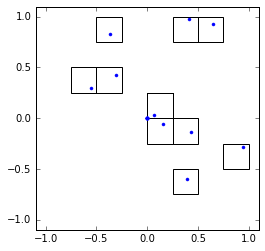

In [230]:
ax = plt.subplot(aspect='equal')
# plot_rectangle(D.children,ax)
# plot_rectangle(D.children[0].children)
# plot_rectangle(D.children[0].children[0].children)
for point in data: 
    plot_rectangle(res[get_bin(point, 2**N, D.mins, D.maxes)])
ax.plot(data[:,0], data[:,1], '.')